# Recurrent networks

- Once we learn the general equation and properties of the line / hyperplane we can turn around and perform various learning tasks - like regression and classification - using it as a model.  


- By the same token now that we have a basic understanding of how to model general ordered data, we can use those models to perform various learning tasks.  


- In this Section we use the generic variable order dynamic system introduced in the previously to perform simple learning tasks on time series.  This is often referred to as Recurrent Neural Networks (or RNNs for short).  RNNs can also be used for more sophisticated time series problems - like machine translation - which we discuss in the next Section.

Activate next cell to toggle code on and off

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is eåxported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')

# import custom lib
from mlrefined_libraries import recurrent_library as reclib

# import dataset path
datapath = '../../mlrefined_datasets/recurrent_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# Using unlimited memory dynamic systems for time series prediction

- Recurrent Neural Networks (RNNs) = the use of [unlimited memory dynamic systems](https://jermwatt.github.io/control-notes/posts/dynamic_systems_unlimited_memory/dynamic_systems_unlimited_memory.html) for learning on time series


- General formula for a simple unlimited memory system 

\begin{equation}
h_p = f\left(h_{p-1},x_p \right).
\end{equation}


- If $f$ here is linear we have

\begin{equation}
h_p = w_0 + w_1h_{p-1} + w_2x_p.
\end{equation}

- To use such a model for any sort of prediction task we

<ol>
  <li>choose a function $f$</li>
  <li> train favorite standard ML scheme on input/output pairs</li>
  <li> to predict next future value feed in *only the most recent value* of the series into the trained model</li>
</ol>

- Making a training set of input/output data for a time series by feeding in the entire series, and "windowing" of ever-increasing size will happen natually

<figure>
<p>
<img src= 'images/windowing_series.png' width="70%" height="70%" alt=""/>
</p>
<figcaption> <strong></strong> <em>  
</em>
</figcaption>
</figure>

- A common sort of model consisting of a simple unlimited memory dynamic system - often called a *Recurrent Neural Network*  and the function $f$ usually chosen as a standard activation function - adds a final linear combination to the final output of the system

\begin{equation}
\text{model}\left(x_p,\Theta\right) = v_0 + h_pv_1
\end{equation}

- Here the parameter set $\Theta$ contains $v_0, v_1$ the weights of the final linear combination, as well as any parameters internal to $h_p = f\left(h_{p-1},x_p \right)$

- For a regression problem this model generates our predicted output


- Denote by 

$$
\,\,\,\,\, \,\,\,   \,\,\,  \,\,\, \,\,\,   \,\,\,   \,\,\,  \,\,    \hat{y}_p:=  \text{model}\left(x_p,\Theta\right)  \\
y_p:= x_p \\
\,\,\,\,\,  \,\,\,\,\,  \,\,\,\,\,  \,\,\,\,\,  \,\,  \ell\left(a,b\right) := \left(a-b \right)^2
$$

- We have a standard Least Squares regression

\begin{equation}
\frac{1}{P-D}\sum_{p=D}^{P}\ell\left(\hat{y}_p,y_p\right)
\end{equation}


- When used for time series prediction we hope hidden states learn interesting and useful *summary statistics* and important *long-term dependencies* - of our entire dataset 


- [Deeper systems with additional hidden layers](https://jermwatt.github.io/control-notes/posts/dynamic_systems_unlimited_memory/dynamic_systems_unlimited_memory.html#deeper-systems) can learn higher order summary statistics


- But present a trade-off: the recursion from $x_p$ all the way to the origin at $x_1$ can be very long, which will be performed during each training update


- This can slow down optimization, and can naturally cause 'exploding/vanishing' gradient problems when using gradient descent 


- Lots of tricks - from careful selection of activation function, to carefully engineered optimization algorithms, to the construction of more complicated activations like the Long Short Term Memory function


- However while *training* is tough, evaluation of trained models are fast (just plug in the most recent value of the series)

#### <span style="color:#a50e3e;">Example 1. </span>  Time series prediction using an RNN

- Below we load in a time series dataset we will perform prediction on


- Note: we will first ["contrast normalize"](https://jermwatt.github.io/control-notes/posts/zca_sphereing/ZCA_Sphereing.html) this series - that is we mean center and re-scale by its standard deviation

<IPython.core.display.Javascript object>


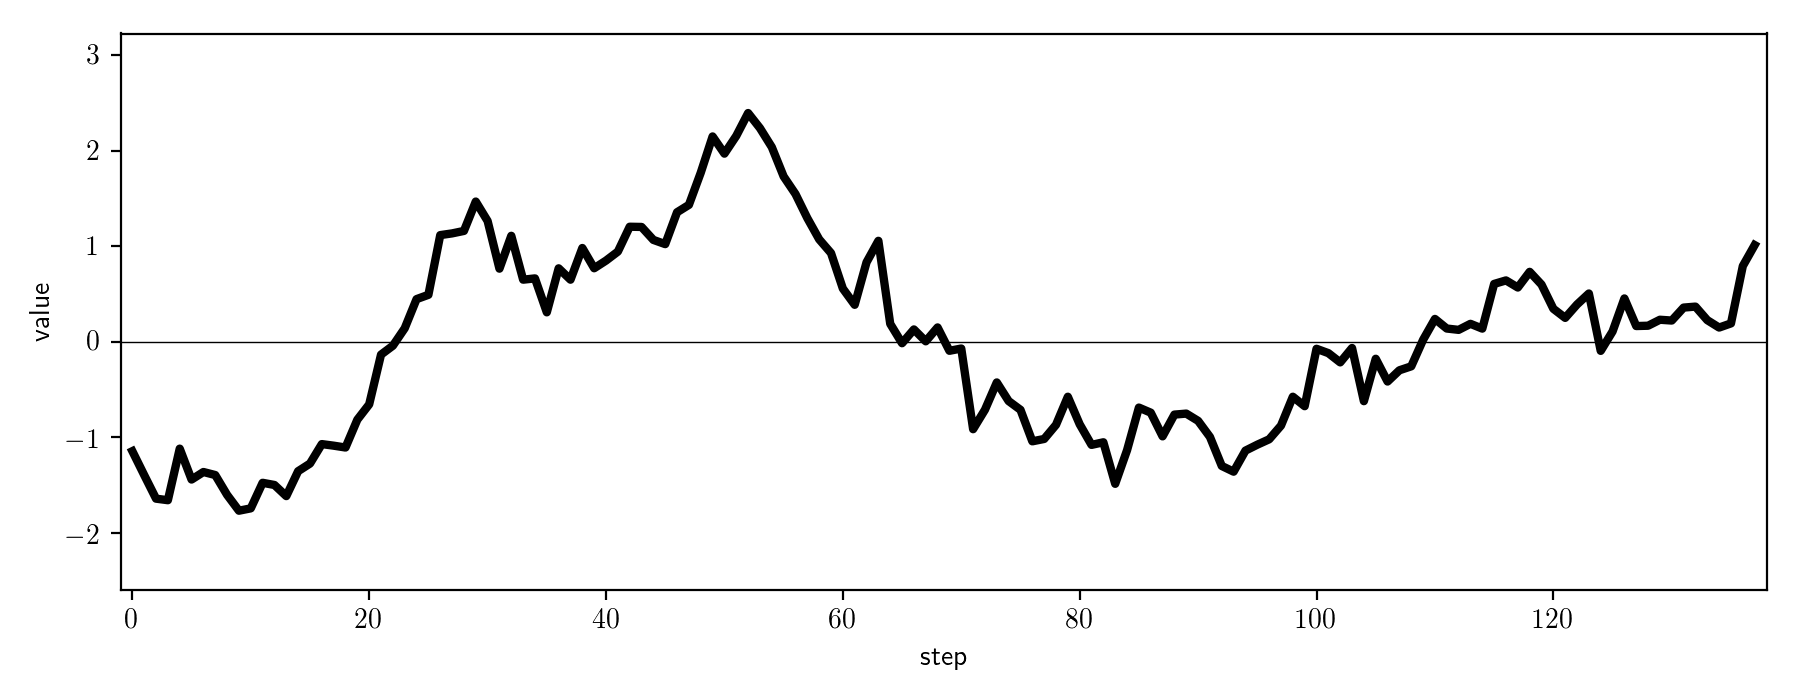

In [6]:
## This code cell will not be shown in the HTML version of this notebook
# load in driver
csvname = datapath + 'normalized_apple_prices.csv'
x_series = np.loadtxt(csvname,delimiter = ',')[np.newaxis,:]

# standard normalize input series
normalizer,inverse_normalizer = reclib.time_series_lib.normalizers.standard(x_series)
x_series = normalizer(x_series)

# Plot the standard normalized series
reclib.time_series_lib.fixed_order_plotters.plot_sequences(x_series)

- We perform training / validate our model precisely as we did previously with the autoregressive process


- Here however, we will be able to learn quite a good model using only a single input at-a-time from the true series


- Plotted below is the training fit (in blue) and validation fit (in yellow) resulting from a run of [derivative free/zero order optimization](https://jermwatt.github.io/machine_learning_refined/notes/2_Zero_order_methods/2_6_Coordinate.html) employing the Least Squares cost function

In [7]:
## This code cell will not be shown in the HTML version of this notebook
def step(h_t_prev,x_t_prev,w):
    return w[0] + w[1]*h_t_prev + w[2]*x_t_prev
    
# exponential average function
def model(x,w):
    # set initial conditions of h to values of x
    h = [x[:,0]]
    
    # range over x and create h
    for t in range(0,np.size(x)-1):
        # get current point and prior hidden state
        h_t_prev = h[-1]
        x_t_prev = x[:,t]

        # make next element and store
        h_t = step(h_t_prev,x_t_prev,w)
        h.append(h_t)
    return np.array(h).T

# an implementation of the least squares cost function for linear regression
def least_squares(w,x,y):
    # compute cost over batch
    cost = np.sum((model(x,w) - y)**2)
    return cost/float(np.size(y))

<IPython.core.display.Javascript object>


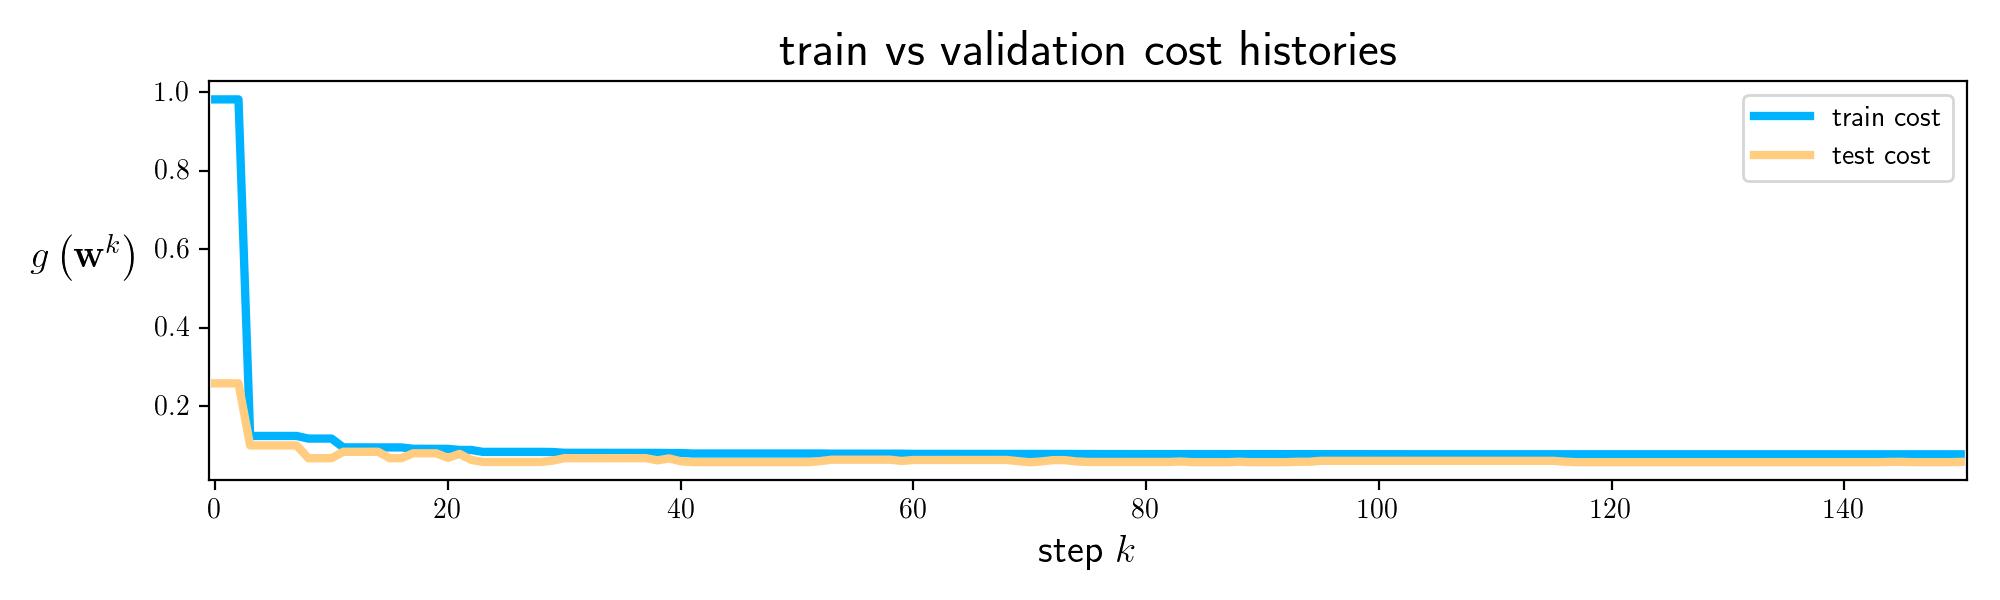

In [10]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib1 = reclib.time_series_lib.rnn_lib.super_setup.Setup(x_series,x_series)

# perform preprocessing step(s) - especially input normalization
mylib1.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib1.make_train_val_split(train_portion = 0.6)

# choose cost
mylib1.choose_cost(name = 'least_squares',model = model,step = step)

# fit an optimization
w = 0.1*np.random.randn(3,1)
mylib1.fit(max_its = 50,alpha_choice = 'diminishing',optimizer = 'zero_order',w_init = w,verbose = False)

# show cost function history
mylib1.show_histories()

<IPython.core.display.Javascript object>


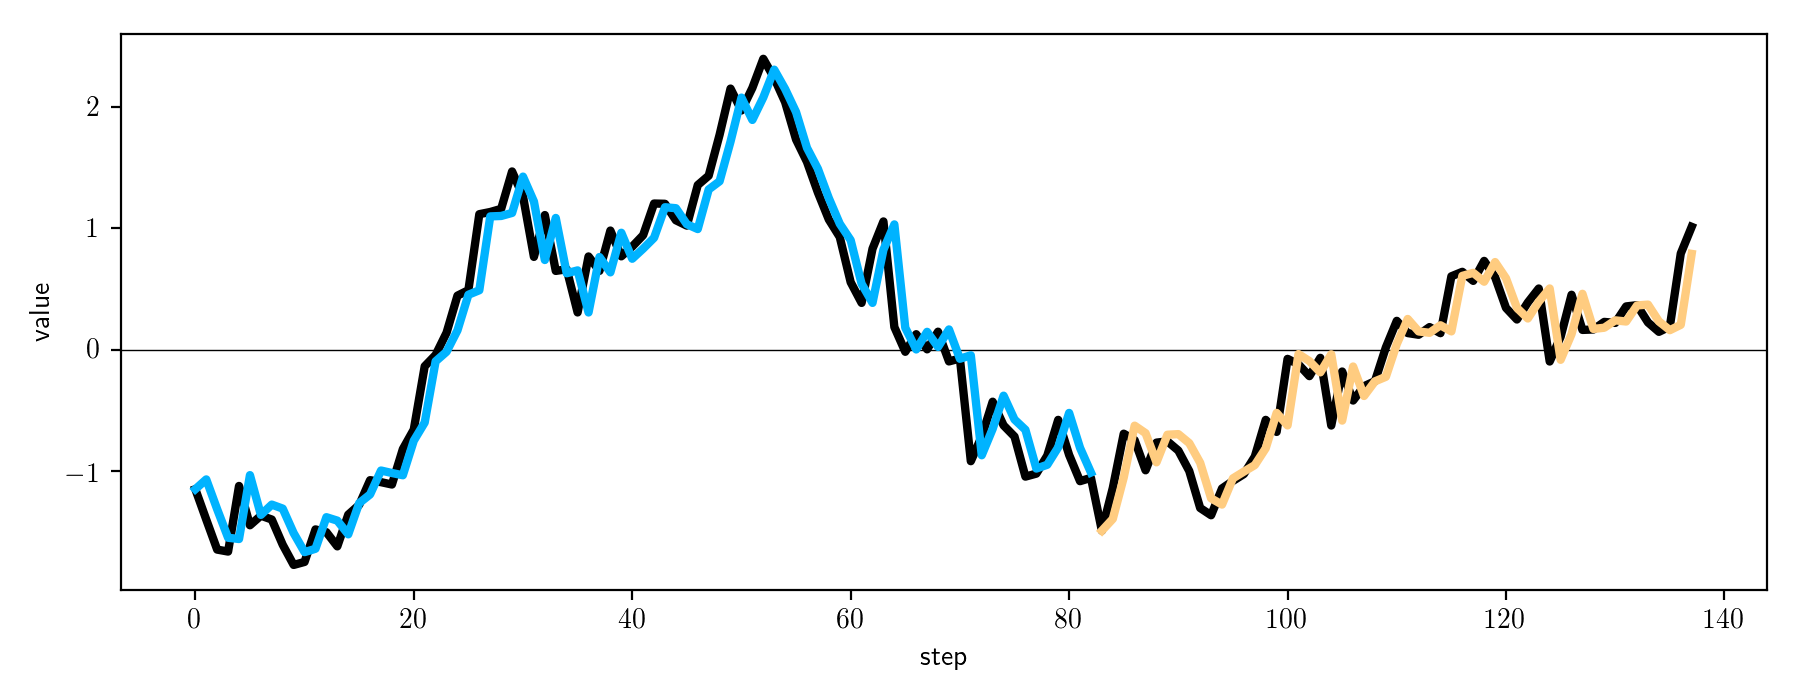

In [11]:
## This code cell will not be shown in the HTML version of this notebook
# Plot the standard normalized series and its training fit
reclib.time_series_lib.variable_order_plotters.plot_train_val_sequences(mylib1)

- As with the autoregressive approach, here we too can use our trained model as a generator

<IPython.core.display.Javascript object>


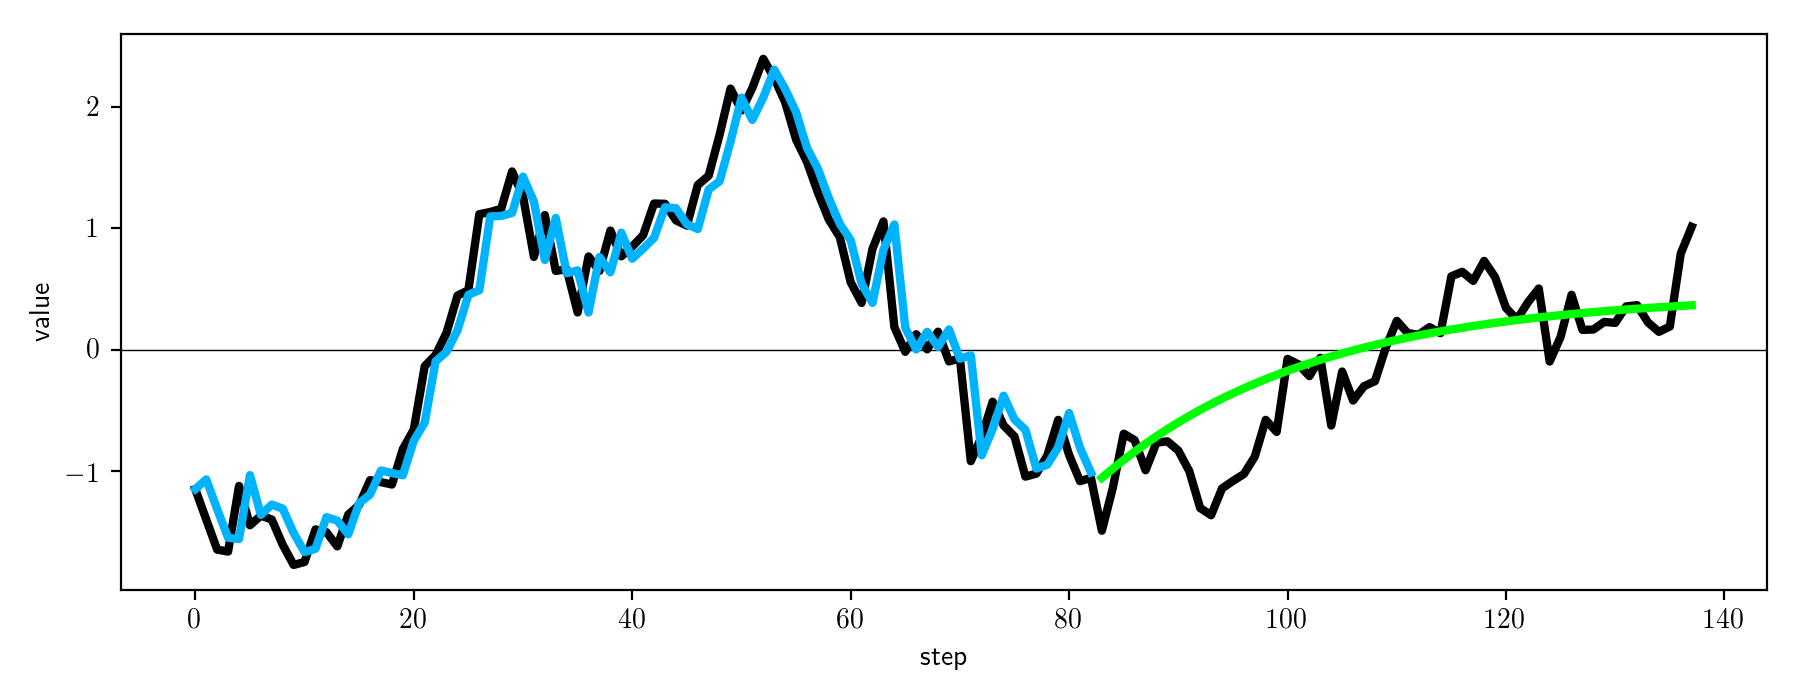

In [13]:
## This code cell will not be shown in the HTML version of this notebook
# Plot the standard normalized series
reclib.time_series_lib.variable_order_plotters.plot_train_gen_sequences(mylib1)